#### Notebook 2 - Retraining using updated labelled data trained from the previous model in Notebook 1 

In this notebook,transfer learning in Natural Language Processing is implemented using the FastAI library.
The Universal Language Fine-tuning for Text Classification paper is applied to classify the sentiment of Yelp reviews as a 5 star rating. 
This method helps to achieve relatively good results with not a huge sample of training data
The labelled dataset used is 50K samples Yelp reviews

To achieve comptutaional backend **Google Colab** was used to implement codes and some of the codes would be specific for implementation in Colab

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Section1 - Loading the libraries

In [0]:
import numpy as np
import pandas as pd
from fastai import *
from fastai.text import *
from fastai.vision import *
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

### Section 2 - Reading and Exploring the data

Using the updated labelled data with 59,638 labelled data points that are evenly distributed across the 5 sentiments

In [4]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/updated_labeled_data.csv')
data.head(3)

,text,label
0,The new rule is - \r\nif you are waiting for a...,4
1,"Flirted with giving this two stars, but that's...",3
2,I was staying at planet Hollywood across the s...,5


In [5]:
print(len(data))

59638


In [6]:
labelall = data['label'].value_counts().index
label_count = data['label'].value_counts()
label_count

1    12024
4    12019
2    11953
5    11830
3    11812
Name: label, dtype: int64

In [7]:
#Splitting the data as test train
df_train, df_test = train_test_split(data[['label', 'text']], test_size=0.2)
df_train = df_train.dropna()
df_test = df_test.dropna()
df_test.head()

,label,text
4298,3,"Came here for dinner last night, been here cou..."
5474,1,The service here is very spotty. We arrive and...
48473,4,The king crab was split not cracked....hot cla...
52876,4,Big park with a beautiful lake! I've only been...
54771,1,"THIEVES!! If you stay here, do NOT TAKE ANYTHI..."


In fastai library, the data processing can be done using the from_df method of the TextLMDataBunch. 
The different steps of preprocessing such as: cleaning, tokenizing, indexing, building vocabulary, etc. are done using this module.

The source code of the pre processing steps can be found at 
https://github.com/fastai/fastai/blob/master/fastai/text/transform.py

text.tranform contains the functions that deal behind the scenes with the two main tasks when preparing texts for modelling: tokenization and numericalization.

Tokenization splits the raw texts into tokens (which can be words, or punctuation signs...). The most basic way to do this would be to separate according to spaces, but it's possible to be more subtle; for instance, the contractions like "isn't" or "don't" should be split in ["is","n't"] or ["do","n't"]. By default fastai will use the powerful spacy tokenizer.

Numericalization is easier as it just consists in attributing a unique id to each token and mapping each of those tokens to their respective ids.

Ref https://docs.fast.ai/text.transform.html

Tokenization step is actually divided in two phases: first, a certain list of rules to the raw texts is applied as preprocessing, then we use the tokenizer to split them in lists of tokens. Combining together those rules, the tok_funcand the lang to process the texts is the role of the Tokenizer class.


This preprocessing is for the language model

In [0]:
data_lm = TextLMDataBunch.from_df('./', df_train, df_test)

In [9]:
data_lm.vocab.itos[:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.',
 'the',
 ',',
 'and',
 'i',
 'to',
 'a',
 'was',
 'it',
 'of',
 'for']

UNK (xxunk) is for an unknown word (one that isn't present in the current vocabulary)

PAD (xxpad) is the token used for padding, if we need to regroup several texts of different lengths in a batch

BOS (xxbos) represents the beginning of a text in your dataset

FLD (xxfld) is used if you set mark_fields=True in your TokenizeProcessor to separate the different fields of texts (if your texts are loaded from several columns in a dataframe)

TK_MAJ (xxmaj) is used to indicate the next word begins with a capital in the original text

TK_UP (xxup) is used to indicate the next word is written in all caps in the original text

TK_REP (xxrep) is used to indicate the next character is repeated n times in the original text (usage xxrep n {char})

TK_WREP(xxwrep) is used to indicate the next word is repeated n times in the original text (usage xxwrep n {word})

### Section 3 - NLP model creation and training and fine tuning
The main thing here is RNNLearner. There are also some utility functions to help create and update text models.

Ref: https://docs.fast.ai/text.learner.html#language_model_learner

The achitecture used is AWD_LSTM as proposed in the ULMFiT paper using a pretrained model. the drop_mult is applied to all the dropouts weights of the config as per various architecture. drop_mult=0.5 as per the documentation for AWD_LSTM


In [0]:
learn = language_model_learner(data_lm, arch = AWD_LSTM, pretrained = True, drop_mult=0.5)

The language model can be tested for a word to see if the sentense formed is reasonable for a given word

In [11]:
# xxbos token stands for the beggining of a sentence
learn.predict('What', 100)

'What a Star Wars " is about scraping down the devil \'s roof at all times " , a reference to the scene of Round Nine Trent near Chester , Thailand , in which Foreigner Guy Henry inherited a priority on the dead rider , hostage ( charging him in chen flames in a hurricane ) and destroying the rest of children ( the crows were mostly forced to run the water speed with " razor " ) wings , leading outer yardbirds up to the pole . The viewing'

lr_find helps to fing a learning rate over iterations
Explores from start_lr(1e-07) to end_lr(10) over num_it iterations(100) in learn, stops when loss diverges.

Ref https://docs.fast.ai/basic_train.html#lr_find
    

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


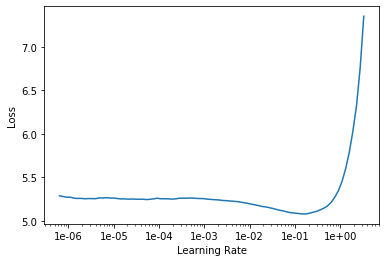

In [12]:
learn.lr_find()
learn.recorder.plot()

Firstly only the last softmax layer is fitted as per ULMFiT paper. fit_one_cycle fits a model following the 1cycle policy.

Ref https://docs.fast.ai/basic_train.html#fit_one_cycle

In [13]:
# First, fit only the last softmax layer
learn.freeze_to(-1)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.042343,3.936049,0.314286,15:27


In [14]:
# Then unfreeze the model and fit it again
learn.unfreeze()
#learn.fit_one_cycle(10, 1e-2)
learn.fit_one_cycle(7, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.750097,3.810277,0.328571,18:16
1,3.671119,3.653999,0.300000,18:13
2,3.573452,3.737997,0.300000,18:15
3,3.454936,3.683061,0.328571,18:16
4,3.350409,3.671488,0.314286,18:16
5,3.260934,3.677851,0.328571,18:18
6,3.211943,3.676581,0.328571,18:20


The above results can be interpretted as the model can predict the next word with an accuracy of 0.32

In [31]:
print(learn.predict('xxbos', n_words=100))

 
 
  The food here was definitely on the menu . No problems with the meal . i started off with the braised beef swiss offered with a shot of Revision . Boom ... It was a good bite of the trout . Lead me to the second course and the second was disappointment . The fish was slightly mushy and the fish were fresh and filling .


We can see the language model now predicts with context to the Yelp dataset as opposed to generic corpus

In [0]:
# Saving the encoder
learn.save_encoder('fine_enc')

#### Now preprocessing for the classifier model

In [0]:
# Preprocess data
data_clas = TextClasDataBunch.from_df('./', df_train, df_test, vocab=data_lm.vocab, bs=32)

In [32]:
# Build a classifier with the same architechure and weights as the language model trained 
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (47710 items)
x: TextList
xxbos xxmaj office staff extremely unprofessional . xxmaj left a message , after 5 days of waiting for a return call , i called again . xxmaj the women who answered the phone , answered the phone laughing , said a person 's name and said " what do you want ? " , i said " excuse me " , she said you heard me what do you want .,xxbos xxmaj great spot stopped in by myself for a quick early dinner was nice to see the had pizza by the slice all day ( most places stop after lunch ) got a couple slices one sausage one meatball service was fast pizza was great nice and crispy good amount of sauce and cheese and the toppings covered the slice . i will definitely be back again,xxbos xxmaj heard about the place through xxmaj groupon . xxmaj get there and there 's a sign on the door that states they are no longer accepting the xxmaj groupon . xxmaj well that 's great , the old bait and switch , get you in the door , you 

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


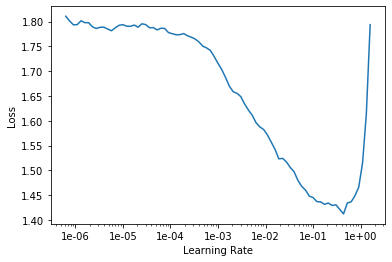

In [33]:
classifier.lr_find()
classifier.recorder.plot()

In [34]:
classifier.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.950095,0.841903,0.643779,08:43


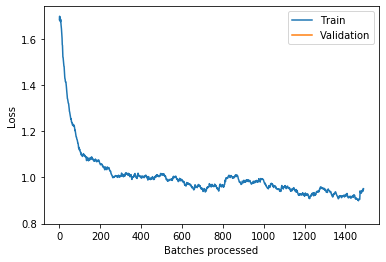

In [35]:
classifier.recorder.plot_losses()

In the below steps the same steps are performed again with the aim of improving accuracy as per the hyperparameter tuning techinques suggested in the ULMFit paper. This includes

1.Dicriminative learning rate
2.One cycle learning
3.Gradual unfreezing

The details can be found at https://arxiv.org/pdf/1801.06146.pdf

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


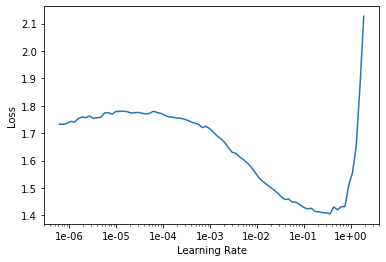

In [36]:
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')
classifier.lr_find()
classifier.recorder.plot()

In [37]:
classifier.fit_one_cycle(1, slice(1e-4, 1e-2), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.935236,0.838687,0.649648,08:18


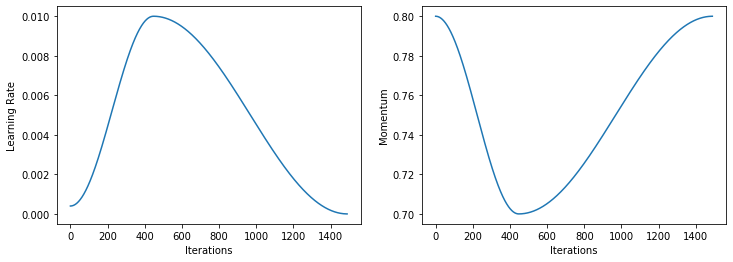

In [24]:
classifier.recorder.plot_lr(show_moms=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


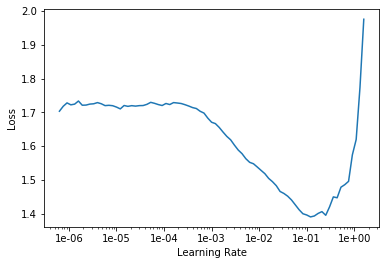

In [25]:
classifier = text_classifier_learner(data_clas, drop_mult=0.5, arch=AWD_LSTM)
classifier.load_encoder('fine_enc')
classifier.lr_find()
classifier.recorder.plot()

In [26]:
classifier.freeze_to(-1)
classifier.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.924423,0.842782,0.645791,08:32


In [27]:
classifier.unfreeze()
classifier.freeze_to(-2)
classifier.fit_one_cycle(1, slice(1e-4, 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.872545,0.778669,0.674883,10:09


In [38]:
classifier.unfreeze()
classifier.freeze_to(-3)
classifier.fit_one_cycle(1, slice(1e-5, 1e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.868384,0.792061,0.668763,18:26


In [39]:
classifier.unfreeze()
classifier.fit_one_cycle(1, slice(1e-4/100., 1e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.860938,0.783969,0.670523,25:26


### Section 4 - Results 

In [0]:
preds, y, losses = classifier.get_preds(with_loss=True)


In [0]:
interp = ClassificationInterpretation(losses=losses, y_true=y, preds=preds, learn=classifier)


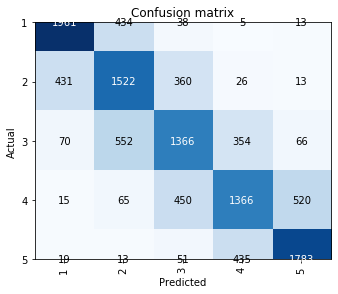

In [42]:
interp.plot_confusion_matrix()

In [43]:
rev = [
    'The pool was 10 times dirty',
    '5 stars',
    ':-(',
    'confused',
    'Loved our stay in this hotel The rooms were amazingly confortable',
    'water was cold and the room not isolated at all', 
    'could have been better',
    'Staff was amazing',
    '',
    'Staff was amazing food was bad',
    'Staff was amazing 123 :-) @super #loveit'
    'Food was great',
    'Food was not bad'
]

for s in rev:
    print(s, '\n=== Predicted:', classifier.predict(s))
    print()

The pool was 10 times dirty 
=== Predicted: (Category 2, tensor(1), tensor([0.2134, 0.4608, 0.2346, 0.0661, 0.0251]))

5 stars 
=== Predicted: (Category 3, tensor(2), tensor([0.0540, 0.2304, 0.3879, 0.2170, 0.1107]))

:-( 
=== Predicted: (Category 1, tensor(0), tensor([0.3495, 0.2588, 0.1383, 0.0985, 0.1549]))

confused 
=== Predicted: (Category 3, tensor(2), tensor([0.1151, 0.2921, 0.3832, 0.1504, 0.0593]))

Loved our stay in this hotel The rooms were amazingly confortable 
=== Predicted: (Category 5, tensor(4), tensor([0.0029, 0.0129, 0.0219, 0.1906, 0.7717]))

water was cold and the room not isolated at all 
=== Predicted: (Category 2, tensor(1), tensor([0.4208, 0.4464, 0.1137, 0.0150, 0.0042]))

could have been better 
=== Predicted: (Category 2, tensor(1), tensor([0.1600, 0.4698, 0.2842, 0.0518, 0.0342]))

Staff was amazing 
=== Predicted: (Category 5, tensor(4), tensor([0.0873, 0.2346, 0.1301, 0.1563, 0.3918]))

 
=== Predicted: (Category 2, tensor(1), tensor([0.2029, 0.2606, 0.1

In [0]:
classifier.export()

In [0]:
#upload and change name of clasifier as export
from pathlib import Path

In [0]:
x = Path('.')

In [0]:
x

PosixPath('.')

In [0]:
classifier = load_learner(x)

#### Predicting the test data labels submitted

In [0]:
test_data = pd.read_csv('/content/test_data.csv')

In [0]:
# do not run this 
test_sub = pd.DataFrame(test_data, columns=("test_id", "text", "label"))
for i in range(0,len(test_sub)):
  predict_for = test_sub.iloc[i,1]
  test_sub.iloc[i,2] = classifier.predict(predict_for)[0]
  
  
test_sub.to_csv('result_semi.csv',index=False)
#test_sub.to_csv('/content/drive/My Drive/Colab Notebooks/result_semi.csv',index=False)

test_sub.head()

In [0]:
# Checking the distribution
sentiment_count = test_sub['label'].value_counts()


In [51]:
sentiment_count

2    11055
1    10348
5     9943
4     9396
3     9258
Name: label, dtype: int64

### Section 5 - Conclusion

The results for test train accuracy are better the semi supervised learning. The Kaggle leaderboard only tests on 30% of the data so we cannot be sure if the accuracy is better for the first model or second but for the assessment purpose we will consider the model using unlaballed data as well

Given better computation facility the whole of unlabelled dataset can be used to make better models